# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:

#Load The data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

#get info about the file
user_log.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
#Have look at the data
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
user_log.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [6]:
print ('There are {} numbe of records'.format(user_log.count()))

There are 286500 numbe of records


In [7]:

#Drop rows with missing values
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")


In [8]:
print ('There are  {} numbe of missing records'.format(user_log.count()-user_log_valid.count()))


There are  8346 numbe of missing records


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

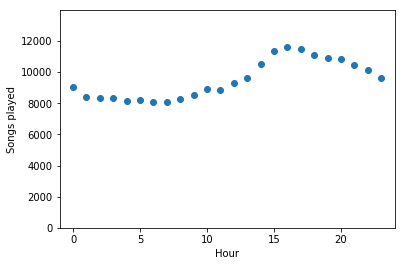

In [9]:
# convert time stamp to hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log.ts))

#calculate songs hourly
songs_in_hour = user_log_valid.filter(user_log_valid.page == "NextSong").groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))

#convert to panda and plot it
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [10]:

user_log_valid.filter(user_log_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()

DataFrame[userId: string]

In [11]:
#Define Churn for "Cancellation Confirmation"
churn_users = user_log_valid.filter(user_log_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
user_log_valid_withchurn = user_log_valid.withColumn("churn", user_log_valid.userId.isin(churn_users_list))

In [12]:
df=user_log_valid_withchurn.toPandas()
df.to_csv(r'sparkify.csv', index = None, header=True)

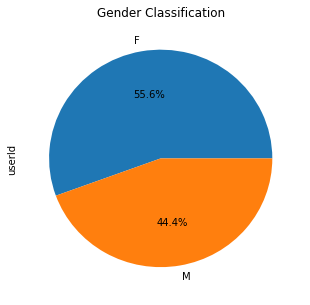

In [13]:
df.groupby('gender').count()['userId'].plot.pie(y='gender', figsize=(5, 5),title='Gender Classification',
 autopct='%1.1f%%')


In [14]:
import os
os.getcwd()

'/home/workspace'

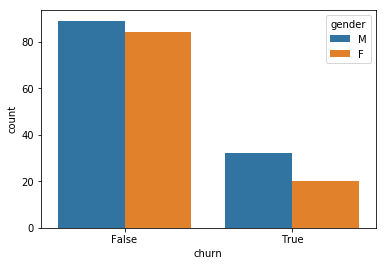

In [15]:
#Convert to panda
user_log_valid_withchurn_pd = user_log_valid_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender' ,data=user_log_valid_withchurn_pd)

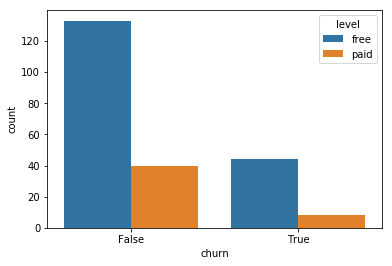

In [16]:
user_log_valid_withchurn_pd = user_log_valid_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='level' ,data=user_log_valid_withchurn_pd)

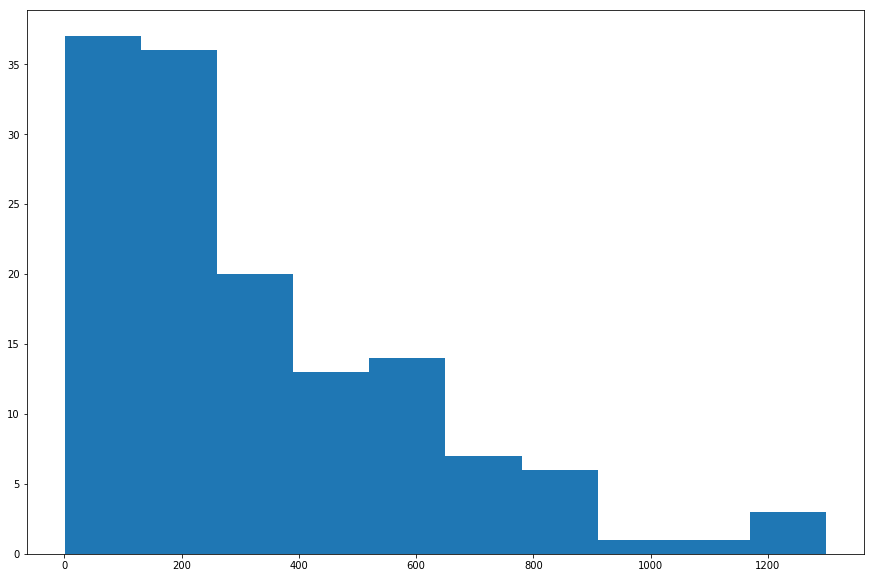

,lifetime
count,44864.000000
mean,52.638062
std,40.006526
min,2.000000
25%,24.000000
50%,43.000000
75%,68.000000
max,188.000000


In [17]:
user_log_valid_withchurn.createOrReplaceTempView("user_log_table_churn")
lifetime=spark.sql("SELECT round(((user_log_table_churn.ts)-(user_log_table_churn.registration))/1000/3600/24,0) as lifetime,user_log_table_churn.userId  FROM user_log_table_churn where churn=True").toPandas()
lifetime.describe()
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(lifetime.groupby('lifetime').count()['userId'],bins=10)
plt.show();

lifetime.describe()



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

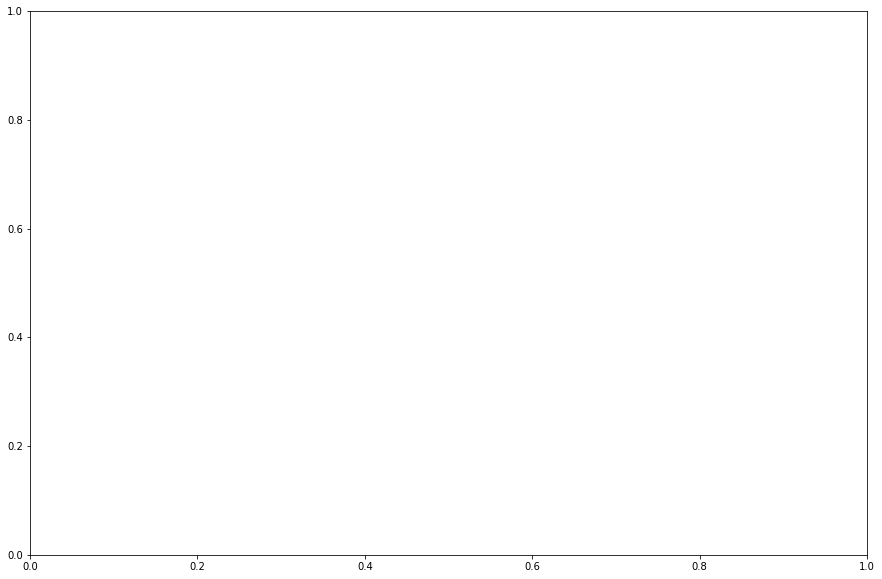

In [18]:
fig, ax = plt.subplots(figsize=(15,10))

In [19]:
#Feature1: lifetime
lifetime=spark.sql("SELECT userId,max(round(((user_log_table_churn.ts)-(user_log_table_churn.registration))/1000/3600/24,0)) as lifetime  FROM user_log_table_churn group by userId ")
lifetime.show(5)

+------+--------+
|userId|lifetime|
+------+--------+
|100010|    56.0|
|200002|    70.0|
|   125|    71.0|
|    51|    19.0|
|   124|   132.0|
+------+--------+
only showing top 5 rows



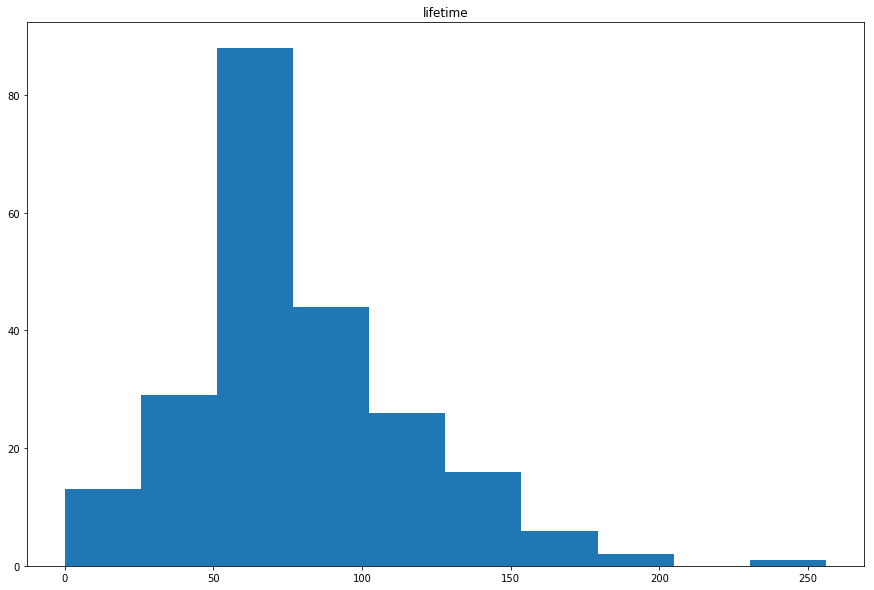

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(lifetime.toPandas().groupby('userId').sum()['lifetime'])
ax.set_title('lifetime')
plt.show();

In [21]:
#Feature2:Thump Up

thumbup=spark.sql("SELECT userId,count(user_log_table_churn.page) as thumbup  FROM user_log_table_churn where page='Thumbs Up' group by userId ")
thumbup.show(5)

+------+-------+
|userId|thumbup|
+------+-------+
|100010|     17|
|200002|     21|
|    51|    100|
|   124|    171|
|     7|      7|
+------+-------+
only showing top 5 rows



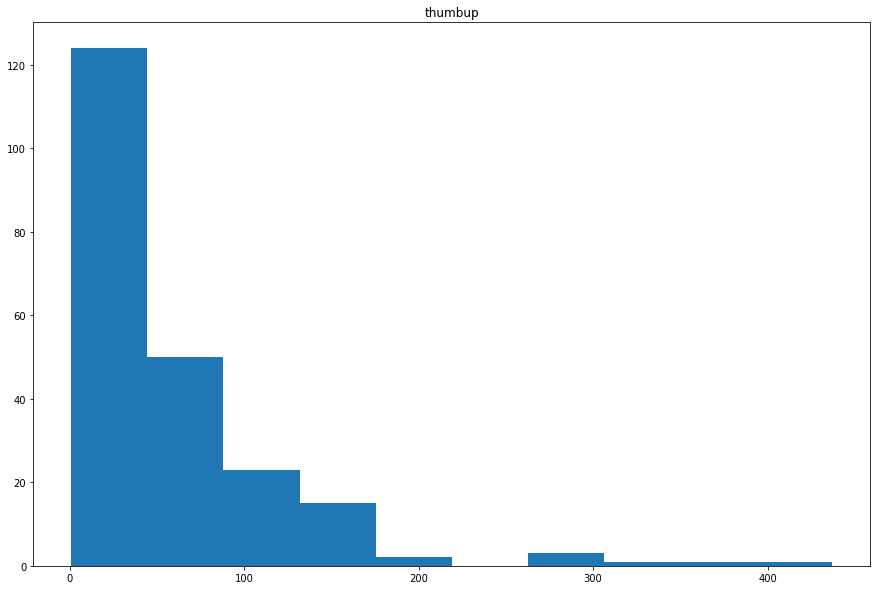

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(thumbup.toPandas().groupby('userId').sum()['thumbup'])
ax.set_title('thumbup')
plt.show();

In [23]:
#Feature 3: Thump Down

thumbdown=spark.sql("SELECT userId,count(user_log_table_churn.page) as thumbdown  FROM user_log_table_churn where page='Thumbs Down' group by userId ")
thumbdown.show(5)

+------+---------+
|userId|thumbdown|
+------+---------+
|100010|        5|
|200002|        6|
|    51|       21|
|   124|       41|
|     7|        1|
+------+---------+
only showing top 5 rows



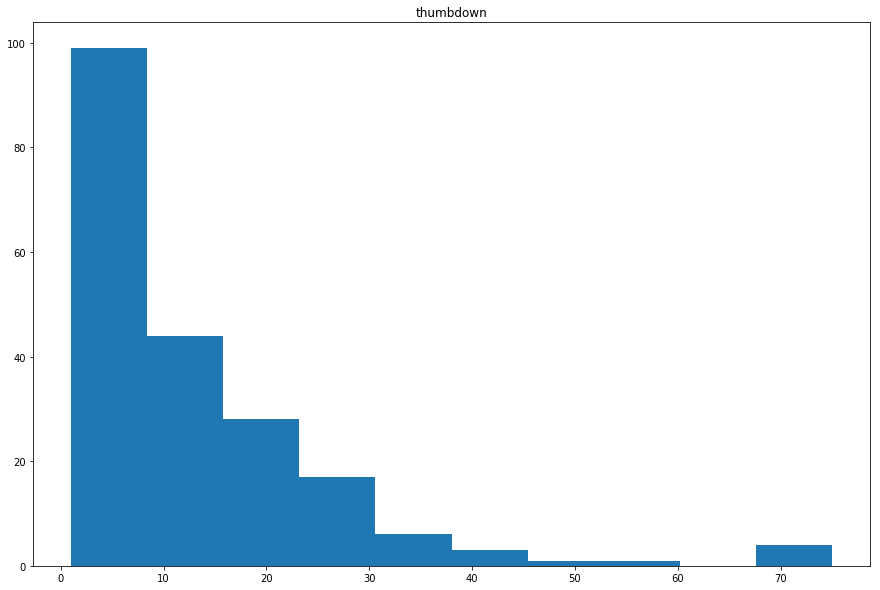

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(thumbdown.toPandas().groupby('userId').sum()['thumbdown'])
ax.set_title('thumbdown')
plt.show();

In [25]:
#Feature 4: Number of songs listened by user

Songs=spark.sql("SELECT userId,count(user_log_table_churn.song) as songs_count  FROM user_log_table_churn group by userId ")
Songs.show(5)

+------+-----------+
|userId|songs_count|
+------+-----------+
|100010|        275|
|200002|        387|
|   125|          8|
|    51|       2111|
|   124|       4079|
+------+-----------+
only showing top 5 rows



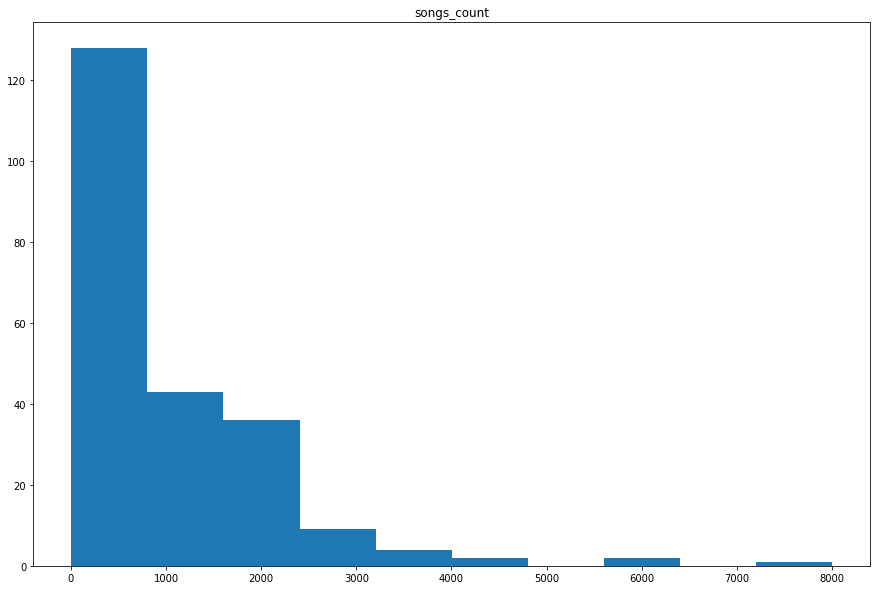

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(Songs.toPandas().groupby('userId').sum()['songs_count'])
ax.set_title('songs_count')
plt.show();

In [27]:
#Feature 5: gender
gender=spark.sql("SELECT distinct userId,cast(replace(replace(user_log_table_churn.gender,'M',0),'F',1) as int) as Gender  FROM user_log_table_churn ")

gender.show(5)



+------+------+
|userId|Gender|
+------+------+
|    69|     1|
|    25|     1|
|100005|     0|
|200002|     0|
|    30|     0|
+------+------+
only showing top 5 rows



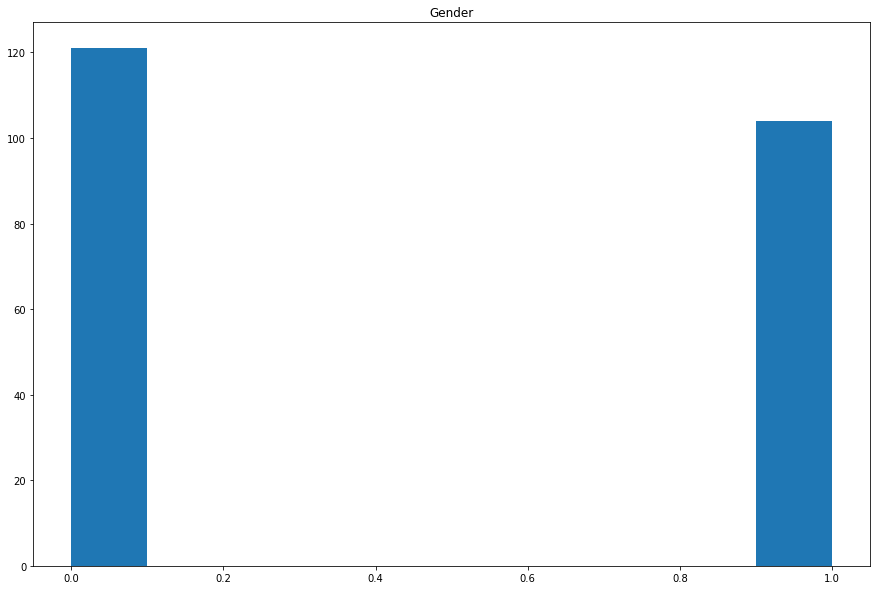

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(gender.toPandas().groupby('userId').sum()['Gender'])
ax.set_title('Gender')
plt.show();


In [29]:
#Feature 6:Number of Artist
Artist=spark.sql("select userId,count(artist) as artist_count from (SELECT distinct user_log_table_churn.userId, user_log_table_churn.artist from user_log_table_churn where user_log_table_churn.page='NextSong' ) group by userId")
Artist.show(5)


+------+------------+
|userId|artist_count|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
+------+------------+
only showing top 5 rows



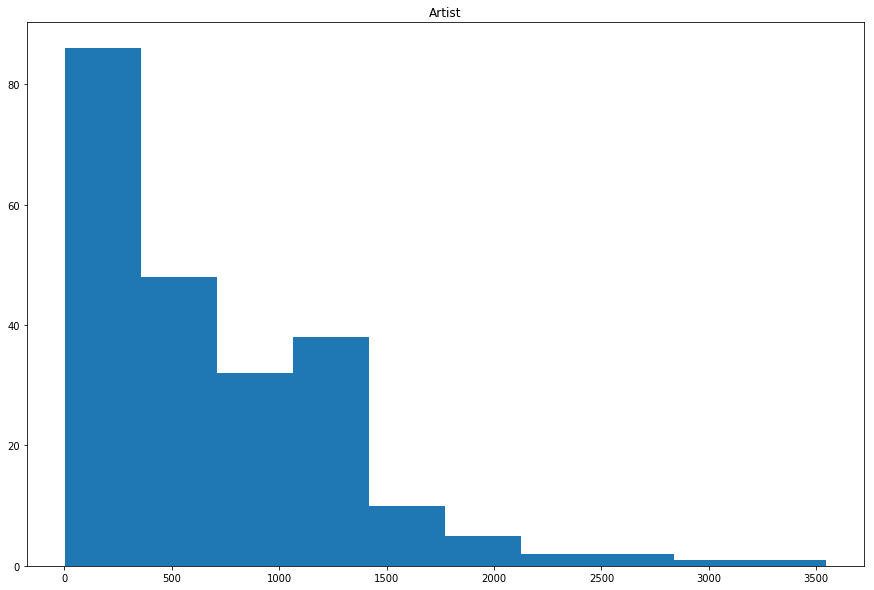

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(Artist.toPandas().groupby('userId').sum()['artist_count'])
ax.set_title('Artist')
plt.show();

In [31]:
#Feature 7
#Songs Added to playlist frpm page "Add to Playlist"
Addlist=spark.sql("SELECT userId,count(user_log_table_churn.page) as page_count  FROM user_log_table_churn where page='Add to Playlist' group by userId ")
Addlist.show(5)



+------+----------+
|userId|page_count|
+------+----------+
|100010|         7|
|200002|         8|
|    51|        52|
|   124|       118|
|     7|         5|
+------+----------+
only showing top 5 rows



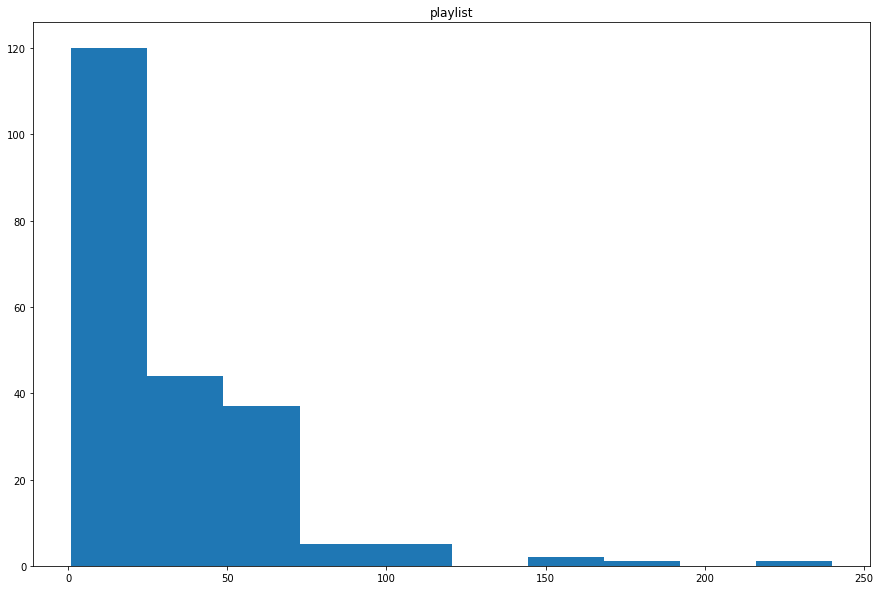

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(Addlist.toPandas().groupby('userId').sum()['page_count'])
ax.set_title('playlist')
plt.show();

In [33]:
#Feature 8

# Duration of listening
listentime=spark.sql("SELECT userId,sum(user_log_table_churn.length) as listentime  FROM user_log_table_churn group by userId ")
listentime.show(5)

+------+------------------+
|userId|        listentime|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



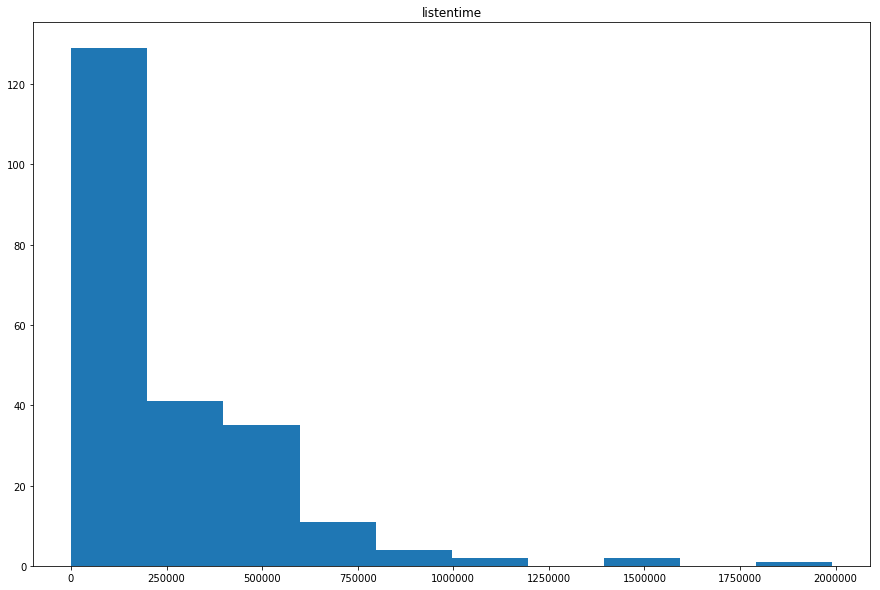

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(listentime.toPandas().groupby('userId').sum()['listentime'])
ax.set_title('listentime')
plt.show();

In [35]:
#Feature 9

# Duration of listening
label=spark.sql("SELECT distinct userId,cast(replace(replace(user_log_table_churn.churn,'false',0),'true',1) as int) as label  FROM user_log_table_churn  ")
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



In [36]:
#Merge the features
final_Features = lifetime.join(thumbup,'userID','outer') \
    .join(thumbdown,'userID','outer') \
    .join(Songs,'userID','outer') \
    .join(gender,'userID','outer') \
    .join(Artist,'userID','outer') \
    .join(Addlist,'userID','outer') \
    .join(listentime,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)
final_Features.show()

+--------+-------+---------+-----------+------+------------+----------+------------------+-----+
|lifetime|thumbup|thumbdown|songs_count|Gender|artist_count|page_count|        listentime|label|
+--------+-------+---------+-----------+------+------------+----------+------------------+-----+
|    56.0|     17|        5|        275|     1|         252|         7| 66940.89735000003|    0|
|    70.0|     21|        6|        387|     0|         339|         8| 94008.87593999993|    0|
|    71.0|      0|        0|          8|     0|           8|         0|2089.1131000000005|    1|
|   132.0|    171|       41|       4079|     1|        2232|       118|1012312.0927899999|    0|
|    19.0|    100|       21|       2111|     0|        1385|        52| 523275.8428000004|    1|
|    73.0|      7|        1|        150|     0|         142|         5| 38034.08710000002|    0|
|    57.0|     81|       14|       1914|     0|        1302|        59|477307.60581000015|    0|
|   111.0|    163|       29|  

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [37]:
# Vector assembler
cols = ["lifetime","thumbup","thumbdown","songs_count","Gender","artist_count","page_count","listentime"]
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(final_Features)
data

DataFrame[lifetime: double, thumbup: bigint, thumbdown: bigint, songs_count: bigint, Gender: int, artist_count: bigint, page_count: bigint, listentime: double, label: int, NumFeatures: vector]

In [38]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
data

DataFrame[lifetime: double, thumbup: bigint, thumbdown: bigint, songs_count: bigint, Gender: int, artist_count: bigint, page_count: bigint, listentime: double, label: int, NumFeatures: vector, features: vector]

In [39]:
#Split to train and test
train, test = data.randomSplit([0.7, 0.3], seed=42)
validation, test = test.randomSplit([0.5, 0.5], seed=42)

# Machine learning Alogorithm will be used
1. Logistic Regression
2. Support Vector Machine 
3. Random Forest
   And will calculate the F1score and the accuracy to be compared



In [40]:
def ML_Model(Alg='lr'):

# initialize 
    if Alg=='lr':
        model= LogisticRegression(maxIter=10)
        method="Logistic Regression:"
    if Alg=='svc':
        model= LinearSVC(maxIter=10)
        method="SVC:"
    if Alg=='rf':
        model= RandomForestClassifier()
        method="Random Forest:"

# evaluator
    evaluator = MulticlassClassificationEvaluator()

# paramGrid
    paramGrid = ParamGridBuilder().build()

    crossval = CrossValidator(estimator=model,evaluator=evaluator, estimatorParamMaps=paramGrid,numFolds=3)

    cvModel = crossval.fit(train)

    results = cvModel.transform(validation)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

    Accuracy=evaluator.evaluate(results, {evaluator.metricName: "accuracy"})
    F1_Score=evaluator.evaluate(results, {evaluator.metricName: "f1"})

    print('Model {}'.format(method))
    print('Accuracy: {}'.format(Accuracy))
    print('F-1 Score:{}'.format(F1_Score))
        
    

Logistic Regression

In [41]:
ML_Model('lr')

Model Logistic Regression:
Accuracy: 0.8333333333333334
F-1 Score:0.7575757575757575


SVM

In [42]:
ML_Model('svc')

Model SVC:
Accuracy: 0.8333333333333334
F-1 Score:0.7575757575757575


Random Forest

In [ ]:
ML_Model('rf')

As we can see from the above analysis Random forest / logistic regression and SVC are giving the same f1_score and accuracy

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.